# Disease analyse

### Context

The Project Tycho database was named after the Danish nobleman Tycho Brahe, who is known for his detailed astronomical and planetary observations. Tycho was not able to use all of his data for breakthrough discoveries, but his assistant Johannes Kepler used Tycho's data to derive the laws of planetary motion. Similarly, this project aims to advance the availablity of large scale public health data to the worldwide community to accelerate advancements in scientific discovery and technological progress.

### Content

The Project Tycho database (level one) includes standardized counts at the state level for smallpox, polio, measles, mumps, rubella, hepatitis A, and whooping cough from weekly National Notifiable Disease Surveillance System (NNDSS) reports for the United States. The time period of data varies per disease somewhere between 1916 and 2010. The records include cases and incidence rates per 10,000 people based on historical population estimates. These data have been used by investigators at the University of Pittsburgh to estimate the impact of vaccination programs in the United States, recently published in the New England Journal of Medicine.

## Load & clean the data

In [1]:
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_data():
    data_file_names = ['hepatitis', 'measles', 'mumps', 'pertussis', 'polio', 'rubella', 'smallpox']
    file_extensions = 'csv'
    folder = 'data'

    data_file_names = [f"{folder}/{name}.{file_extensions}" for name in data_file_names]
    
    for file_path in data_file_names:
        yield pd.read_csv(file_path)

In [3]:
df = pd.concat(get_data())
df

,week,state,state_name,disease,cases,incidence_per_capita
0,196601,AL,ALABAMA,HEPATITIS A,5,0.14
1,196601,AR,ARKANSAS,HEPATITIS A,11,0.58
2,196601,AZ,ARIZONA,HEPATITIS A,6,0.37
3,196601,CA,CALIFORNIA,HEPATITIS A,89,0.47
4,196601,CO,COLORADO,HEPATITIS A,1,0.05
...,...,...,...,...,...,...
50911,195226,NM,NEW MEXICO,SMALLPOX,1,0.14
50912,195227,NV,NEVADA,SMALLPOX,1,0.55
50913,195239,MT,MONTANA,SMALLPOX,1,0.17
50914,195244,SD,SOUTH DAKOTA,SMALLPOX,1,0.15


### Get the date

The 'week' column is a concatenation of a year and a week number. We need a real date.

In [4]:
def to_date(date):
    """
    Transforms a date in the "yearweek" format into a real date.
    """
    year, week = date[:4], date[4:] 
    return datetime.strptime(f'{year}-{week}-1', '%Y%W-%w')

In [5]:
# We transform the dates into datetime objects, then strip the time to keep only the date itself (with .dt.date)
df['date'] = pd.to_datetime(df['week'].apply(lambda x: str(x) + '-1'), format='%Y%W-%w')
df.head()

,week,state,state_name,disease,cases,incidence_per_capita,date
0,196601,AL,ALABAMA,HEPATITIS A,5,0.14,1966-01-03
1,196601,AR,ARKANSAS,HEPATITIS A,11,0.58,1966-01-03
2,196601,AZ,ARIZONA,HEPATITIS A,6,0.37,1966-01-03
3,196601,CA,CALIFORNIA,HEPATITIS A,89,0.47,1966-01-03
4,196601,CO,COLORADO,HEPATITIS A,1,0.05,1966-01-03


In [6]:
df = df.drop('week', axis=1)

### Remove \N values

For some reason, this dataset has several "\\N" values. Replace them with a 0.

In [7]:
df = df[df.cases != '\\N']
df['cases'] = df.cases.astype(int)

### Save the data
Save the cleaned data to a .csv file

In [8]:
df.to_csv('data/complete.csv')

## Visualize the data

In [9]:
# output to notebook
output_notebook()

hover_tool = HoverTool(tooltips=[
    ('Incidence per capita', '$y‰'),
    ('Disease', '$name'),
    ('Date', '$x{%F}')
], formatters={'$x': 'datetime'})

COLORS = ['red', 'orange', 'blue', 'black', 'green', 'purple', 'pink']

def plot_diseases(title, rolling_window = None):
    # create a new plot with a title and axis labels
    p = figure(title=title, x_axis_label='date', y_axis_label='Incidence Per Capita', x_axis_type='datetime')
    p.add_tools(hover_tool)

    x = False
    # add a line renderer with legend and line thickness
    for disease, color in zip(df.disease.unique(), COLORS):
        disease_df = df[df.disease == disease].groupby('date').agg({'incidence_per_capita': 'mean'}).reset_index()
        
        if rolling_window:
            disease_df['incidence_per_capita'] = disease_df[['incidence_per_capita']].rolling(rolling_window, min_periods=1).mean()        
        p.line(disease_df.date, disease_df.incidence_per_capita, legend_label=disease, name=disease, line_width=2, color=color)

    p.legend.location = 'top_right'
    p.legend.click_policy = 'hide'

    # show the results
    show(p)

plot_diseases("Diseases Incidence Per capita ( 1‰ ), Per Month")

Loading BokehJS ...

As we can see:

* Measles ("Rougeole"), at its peak, infected more than 5% of the US population. If the Coronavirus had infected 5.6% of the population, 3 796 800 person would be infected in France (7 730 today), and 79 403 133 in China (80 884 today).

* Pertussis (Whooping Cough - "Coqueluche") is still infecting people today, despite the existence of a vaccine

* Smallpox ("Variole") has the smallest average incidence per capita. Its vaccine was created in the late 18th century, and this disease got completely eradicated in the late 1980s. It is still, today, the only disease able of infecting humans that got eradicated.

* We can see that disease are affected by the season, temperature, climate...

* But it's complicated to see the change throughout the years because of the seasonal changes.

In [10]:
plot_diseases("Diseases Incidence Per capita ( 1‰ ), Rolling Average of a year", 52)

When hiding Measles, we can focus on other diseases. We notice that:

* Polio lowered in 1955. The first polio vaccine was discovered in 1950, but the US refused to use it. A second vaccine came in the beginning of 1955, and got quickly adopted through the country.

* The Rubella vaccine, discovered in 1969, worked pretty well. It's considered one of the safest vaccine by the World Health Organisation.

* It seems the 2nd World War didn't affect much the US. We must remember that the US didn't got any civilian casualties during this war. The results are probably very different in European and Asian countries, since war increases the propagation of diseases.

In [11]:
plot_diseases("Diseases Incidence Per capita ( 1‰ ), Rolling Average of 2 years", 52*2)

We can notice that:

* After the discovery of a vaccine for measles (1963) and its improvement (1968), the incidence per capita of measles sharply lowered

### Which state is the most infected?

Let's display the 5 states which got the most infected (in incidence per capita) by each disease

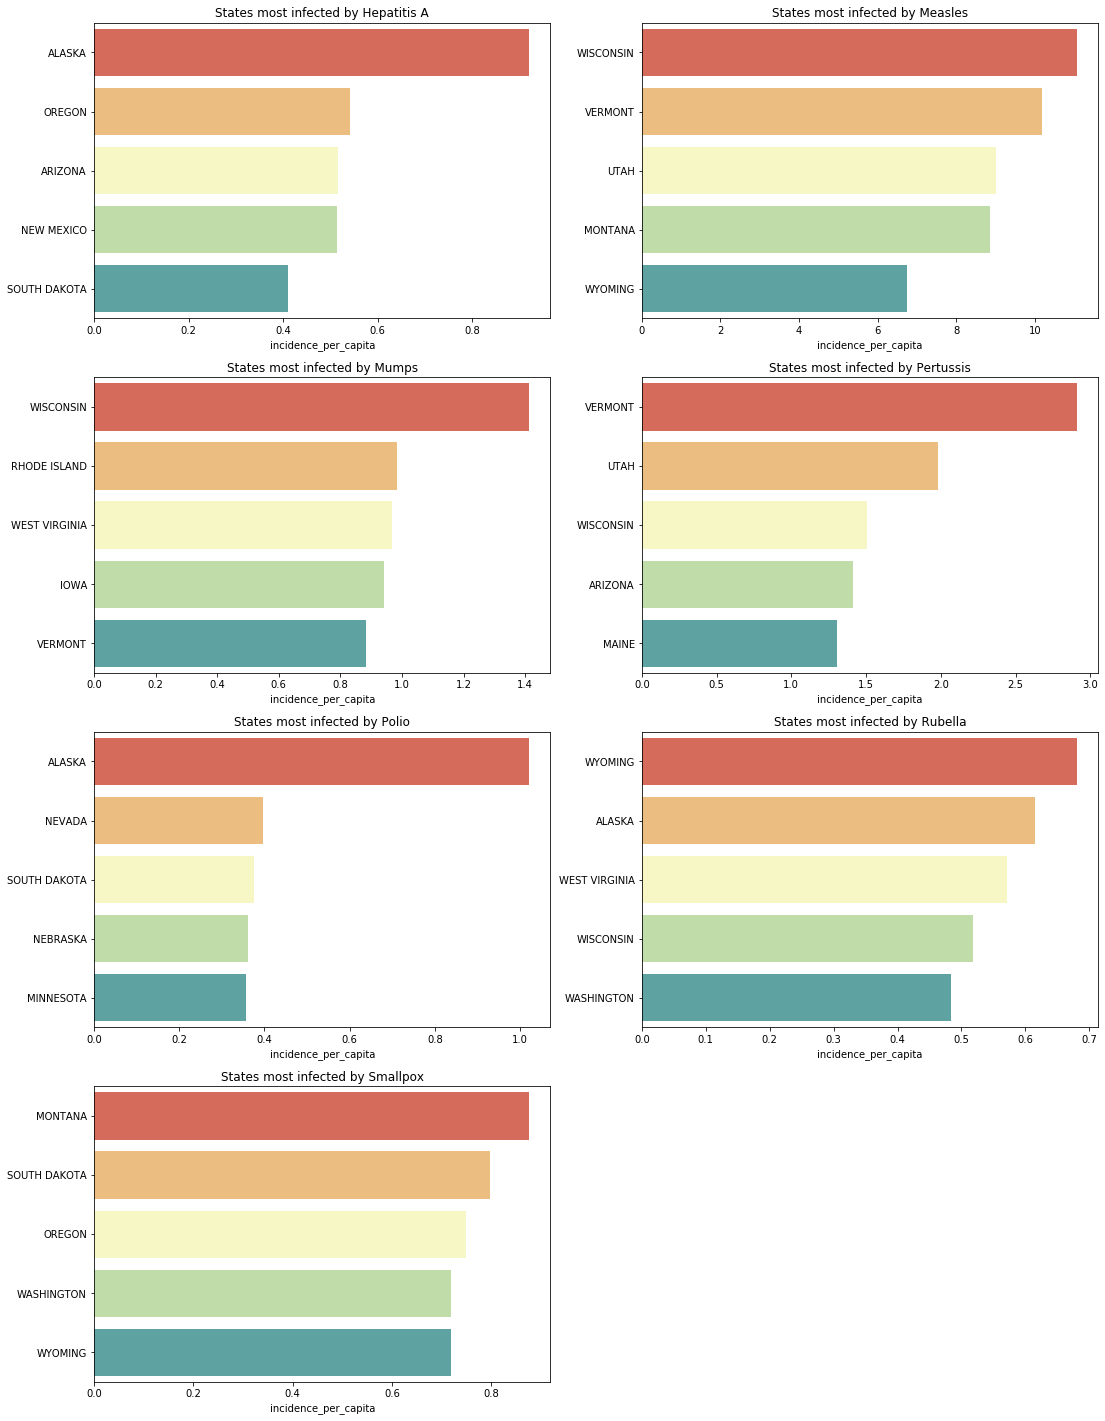

In [12]:
disease_df = df.groupby(['disease', 'state_name']).agg({'incidence_per_capita': 'mean'}).reset_index()

TOP_STATES = 5

plt.figure(figsize=(18,25))

for i, disease in enumerate(df.disease.unique()):
    data = disease_df[disease_df.disease == disease]
    data = data.sort_values('incidence_per_capita', ascending=False).iloc[:TOP_STATES, :]
    
    plt.subplot(4, 2, i+1,  title=f'States most infected by {disease.title()}')
    sns.barplot(x='incidence_per_capita',y='state_name', data=data, palette='Spectral').set_ylabel(None)
    
plt.show()

We can see that:

* This metric is biased toward small states, because of their small population

* Disease have very different maximum incidence per capita

Let's do this again, but this time with the number of cases

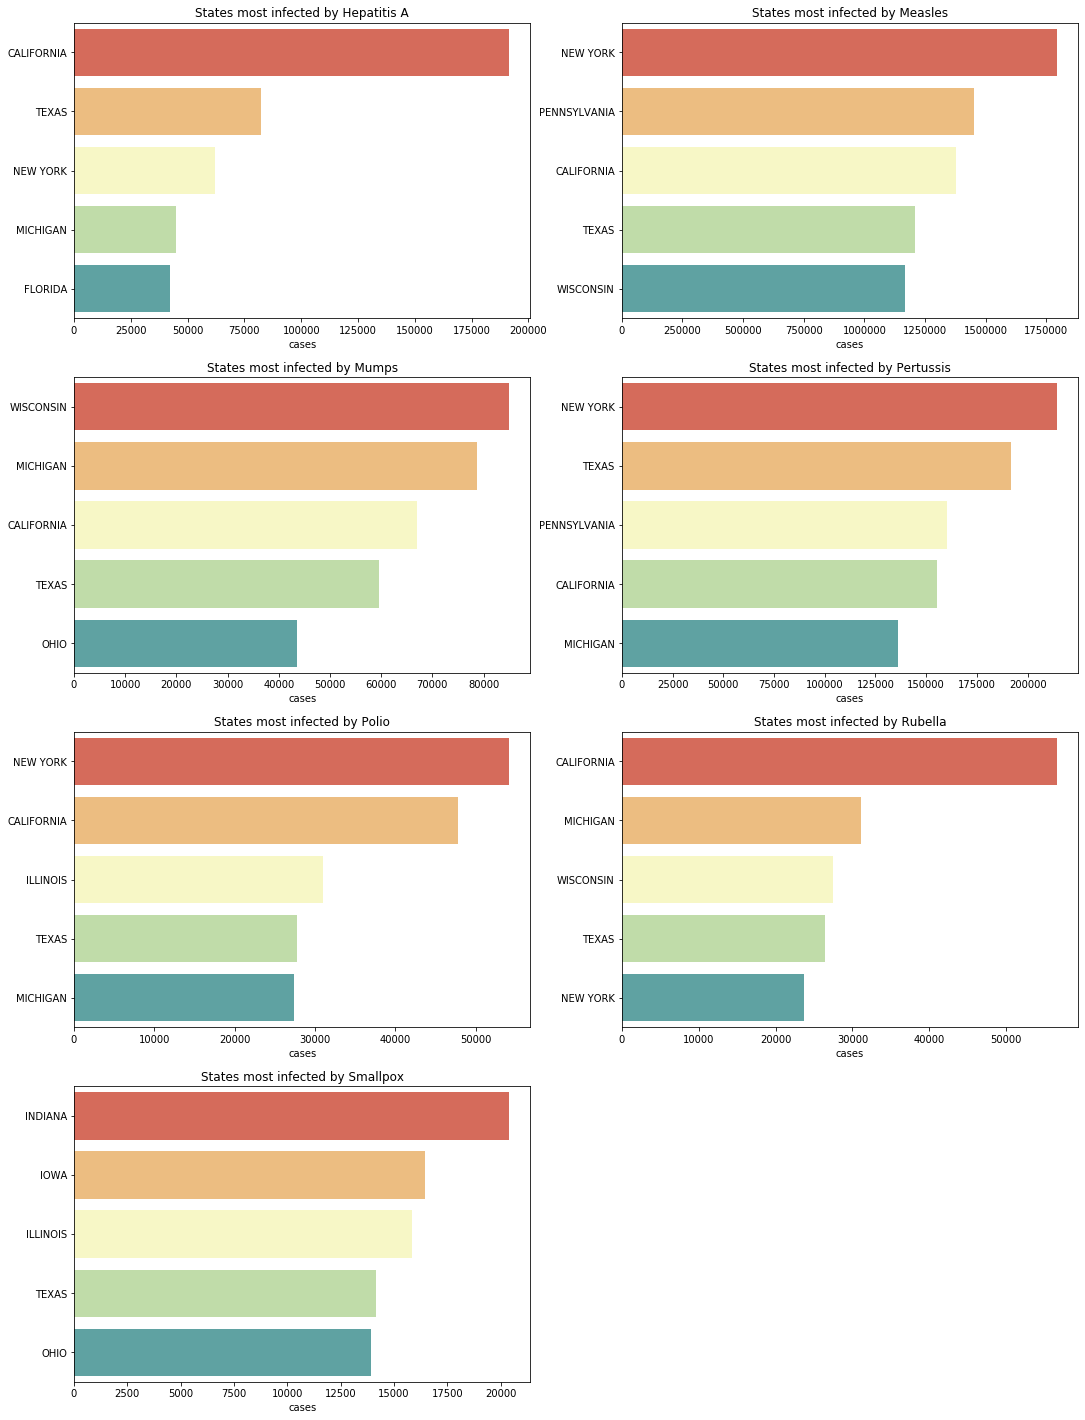

In [13]:
disease_df = df.groupby(['disease', 'state_name']).agg({'cases': 'sum'}).reset_index()

plt.figure(figsize=(18,25))

for i, disease in enumerate(df.disease.unique()):
    data = disease_df[disease_df.disease == disease]
    data = data.sort_values('cases', ascending=False).iloc[:TOP_STATES, :]
    
    plt.subplot(4, 2, i+1,  title=f'States most infected by {disease.title()}')
    sns.barplot(x='cases',y='state_name', data=data, palette='Spectral').set_ylabel(None)
    
plt.show()

This time, the metric is more biased toward dense states. We can conclude that:

* When taking a global view, the incidence per capita is better than the number of cases, which are not related to the total population (and therefore not significant)

* But when comparing local regions, the incidence per capita will be biased toward small states. Using the number of cases can be a good approximation for such cases.

For the last vizualisation, we'll use a weighted average incidence per capita.

## Display geospatial data

To display our data with the python Kepler.Gl package, we need first to convert them into GeoJSON and map Polygons to our different states.

First, we get a mapping from state name to polygon.

In [14]:
import geopandas as gpd

# Get the states polygons
gdf = gpd.read_file('data/states/ne_110m_admin_1_states_provinces.shp')
gdf['code'] = gdf['iso_3166_2'].apply(lambda x: x.split('-')[1])
gdf = gdf[['name', 'geometry', 'code']]

gdf.head()

,name,geometry,code
0,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN
1,Montana,"POLYGON ((-116.04823 49.00037, -113.05950 49.0...",MT
2,North Dakota,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",ND
3,Hawaii,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",HI
4,Idaho,"POLYGON ((-116.04823 49.00037, -115.96780 47.9...",ID


Then, we add the polygons to our Data Frame

In [15]:
# A map between the state and its polygon
states_geometry = gdf[['name', 'geometry']].set_index('name').drop_duplicates().to_dict()['geometry']

# Merge the df
full = gdf.merge(df, left_on = 'code', right_on = 'state', how = 'left')
full = full.groupby(by=['disease', 'name', 'date']).agg({'cases': 'count', 'incidence_per_capita': 'mean'}).reset_index()

full['geometry'] = full['name'].map(states_geometry)
full = gpd.GeoDataFrame(full)

full = full[full.incidence_per_capita > 0]
full = full.drop('cases', axis=1)

full

,disease,name,date,incidence_per_capita,geometry
0,HEPATITIS A,Alabama,1966-01-03,0.14,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
1,HEPATITIS A,Alabama,1966-01-10,0.09,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
2,HEPATITIS A,Alabama,1966-01-17,0.06,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
3,HEPATITIS A,Alabama,1966-01-24,0.12,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
4,HEPATITIS A,Alabama,1966-01-31,0.20,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
...,...,...,...,...,...
600391,SMALLPOX,Wyoming,1947-08-25,0.39,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
600421,SMALLPOX,Wyoming,1948-04-19,0.19,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
600432,SMALLPOX,Wyoming,1950-02-20,0.69,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
600433,SMALLPOX,Wyoming,1951-10-22,0.34,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."


Doing an analysis on the whole dataset is too computational expensive. We merge the data per year in order to lower the number of data points.

In [16]:
# Merge data per year
partial = full.copy()
partial['year'] = partial.date.dt.year
partial = partial.groupby(['disease', 'name', 'year']).agg({'incidence_per_capita': 'mean', 'geometry': 'first'}).reset_index()

# Transform the "year" into a timestamp
partial.loc[:, 'year'] = pd.to_datetime(partial.year, format='%Y').apply(lambda x: x.isoformat())
partial = gpd.GeoDataFrame(partial)
partial

,disease,name,year,incidence_per_capita,geometry
0,HEPATITIS A,Alabama,1966-01-01T00:00:00,0.185600,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
1,HEPATITIS A,Alabama,1967-01-01T00:00:00,0.171837,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
2,HEPATITIS A,Alabama,1968-01-01T00:00:00,0.176538,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
3,HEPATITIS A,Alabama,1969-01-01T00:00:00,0.224898,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
4,HEPATITIS A,Alabama,1970-01-01T00:00:00,0.231373,"POLYGON ((-88.16696 34.99967, -86.90968 34.999..."
...,...,...,...,...,...
13833,SMALLPOX,Wyoming,1947-01-01T00:00:00,0.390000,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
13834,SMALLPOX,Wyoming,1948-01-01T00:00:00,0.190000,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
13835,SMALLPOX,Wyoming,1950-01-01T00:00:00,0.690000,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."
13836,SMALLPOX,Wyoming,1951-01-01T00:00:00,0.340000,"POLYGON ((-111.08518 44.50615, -111.06719 44.5..."


In [25]:
from keplergl import KeplerGl
map_0 = KeplerGl(height=800, data={"diseases": partial})
map_0

On this map, we notice a few interesting things:

* The Hepatitis A vaccine, discovered in 1990, was authorized in 1995 in the US. It was obviously pretty effective.

* The West of the US was most of the time more infected than the East. The climate, or maybe the quality of life could explain this difference.

* Alaska is a pretty interesting state. Due to low population and isolation, most of the time, it gets infected way after the other states. However, once it gets infected, the disease infects a huge percentage of the population at once.

* The same goes for Hawaii

* Measles got totaly eradicated in the US after the years ~2000. It got lowered two times: once after the discovery of its vaccine, and the other time in the recent years (probably due to better access to hygiene)